# Initialization

## Imports

In [ ]:
import torch
import numpy as np
import random

## Hyperparameters

In [ ]:
RANDOM_STATE = 42
TRAIN_SIZE = 0.7

batch_size  = 10
learning_rate = 0.001
num_epochs = 5
num_threads = 2
lr = 0.001

test_size = 0.2

In [ ]:
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data Loading

In [ ]:
from torch.utils.data import DataLoader, Dataset, random_split
import os
from torch.nn import utils
import torch.nn.functional as F
from torch import Tensor
from sklearn.model_selection import StratifiedShuffleSplit
from typing import Tuple, List
from torch import nn
import torchaudio as T

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p ./dataset
!unzip -q /content/drive/MyDrive/datasets/ML/birdclef-2023.zip -d ./dataset

replace ./dataset/eBird_Taxonomy_v2021.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Modules and Functions Declaration

In [ ]:
class BloomSoundDataset(Dataset):
  def __init__(self, root_dir: str, bloom_size=4, bloom_lim=3):
    self.file_list = []
    self.label_list = []
    self.labels = []

    for label in os.listdir(root_dir):
      self.labels.append(label)
      label_dir = os.path.join(root_dir, label)
      dir_files = os.listdir(label_dir)

      if len(dir_files) <= bloom_lim and bloom_size is not None:
        bloom = [dir_files[0] for _ in range(bloom_size - bloom_lim)]
        dir_files.extend(bloom)

      for file_name in dir_files:
        file_path = os.path.join(label_dir, file_name)
        self.file_list.append(file_path)
        self.label_list.append(label)

  def __len__(self) -> int:
    return len(self.file_list)
  
  def __getitem__(self, idx) -> Tuple[Tensor, int]:
    waveform, sample_rate = T.load(self.file_list[idx])
    label = self.labels.index(self.label_list[idx])
    return waveform, label

In [ ]:
class SoundDataLoader(DataLoader):
  def __init__(self, **kwargs):
    super(SoundDataLoader, self).__init__(
      **kwargs,
      collate_fn = self.custom_collate_fn
    )

  def custom_collate_fn(self, batch: List) -> Tuple[List[Tensor], Tensor]:
    data = [item[0] for item in batch]
    target = torch.tensor([item[1] for item in batch])
    return data, target

In [ ]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

## Dataloader Instantiation

In [ ]:
dataset = BloomSoundDataset('./dataset/train_audio')

In [ ]:
g = torch.Generator()
g.manual_seed(0)

In [ ]:
dataset_size = len(dataset)
train_size = int(TRAIN_SIZE * dataset_size)
val_size = dataset_size - train_size

train_dataset, val_dataset = random_split(
    dataset, 
    [train_size, val_size],
    generator=g
)

In [ ]:
train_dl = SoundDataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    num_workers=num_threads,
    worker_init_fn=seed_worker,
    generator=g,
)
valid_dl = SoundDataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_threads,
    worker_init_fn=seed_worker,
    generator=g,
)

# Transforms Declaration

## Imports

In [ ]:
from torch import nn
import pywt
import torchaudio.transforms as TT
import torch.nn.functional as F
from torchvision import models, transforms
import matplotlib.pyplot as plt

## Module Declaration

In [ ]:
class ToIntervals(nn.Module):
  def __init__(self, seconds=5, sample_rate=32000):
    super(ToIntervals, self).__init__()
    self.seconds = seconds
    self.sample_rate = sample_rate

  """
    waves shape: (batch x 1 x wave_len) as List
    labels shape: (batch) as Tensor
  """
  def forward(
      self, waves: List[torch.Tensor], 
      labels: torch.Tensor | None = None
  ) -> torch.Tensor:
    interval_window = self.seconds * self.sample_rate

    intervals = []
    bloomed_labels = []
    for i, wave in enumerate(waves):
      pad = (interval_window - wave.shape[-1] % interval_window) \
                  % interval_window
      wave = F.pad(wave.unsqueeze(1), (0, pad), mode='replicate') \
                  .squeeze(0).view(-1, interval_window)
      intervals.append(wave.unsqueeze(1))
      if labels is not None:
        bloomed_labels.extend(
          [labels[i] for ii in range(wave.shape[0])]
        )
    cat_waves = torch.cat(intervals, dim=0)
    if labels is None: return cat_waves, None
    cat_labels = torch.stack(bloomed_labels)

    return cat_waves, cat_labels

In [ ]:
class WaveletTransform(nn.Module):
  def __init__(
      self, 
      wavelet: pywt.Wavelet,
      cut_to_nearest: int | None = None
  ):
    super(WaveletTransform, self).__init__()
    self.wavelet = wavelet
    self.ctn = cut_to_nearest

  def forward(self, X: torch.Tensor) -> torch.Tensor:
    items = X.cpu().numpy()
    out = None
    for item in items:
      wh, wl = pywt.dwt(item[0], self.wavelet)
      ca = torch.stack((torch.from_numpy(wh), torch.from_numpy(wl)))
      if out is None:
        out = ca.unsqueeze(0)
      else:
        out = torch.cat([out, ca.unsqueeze(0)], dim=0)
    
    if self.ctn is not None:
      out = out[:,:,:-1 * (out.shape[-1] % self.ctn)]
    # return out.to(device).unsqueeze(1)
    return out.to(X.device)

In [ ]:
class AudioAugmentations(nn.Module):
  def __init__(
      self, 
      stretch_rate=0.8,
      fixed_rate=True,
      freq_mask_param=30,
      time_mask_param=80
  ):
    super(AudioAugmentations, self).__init__()
    self.aug = nn.Sequential(
        TT.TimeStretch(stretch_rate, fixed_rate=fixed_rate),
        TT.FrequencyMasking(freq_mask_param=freq_mask_param),
        TT.TimeMasking(time_mask_param=time_mask_param),
    )
  
  def forward(self, X: torch.Tensor) -> torch.Tensor:
    return self.aug(X)

In [ ]:
class AudioTransforms(nn.Module):
  def __init__(
      self, 
      input_freq=32000,
      n_fft=1200,
      n_mels=128
  ):
    super(AudioTransforms, self).__init__()

    # mel spectogram automatically converts to 0-1, but DB converts -100 to n_mels
    self.m_spec = nn.Sequential(
        TT.MelSpectrogram(sample_rate=input_freq, n_fft=n_fft, n_mels=n_mels),
        TT.AmplitudeToDB(),
    )
  
  def forward(self, x: Tensor) -> Tensor:
    val = self.m_spec(x)
    return val

In [ ]:
class Tensored(nn.Module):
  def __init__(self):
    super(Tensored, self).__init__()
    self.transforms = transforms.Compose([
      transforms.ToPILImage(),
      transforms.ToTensor(),
      # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
      transforms.Normalize(0.5, 0.5)
    ])

  def forward(self, X: Tensor) -> Tensor:
    items = [self.transforms(item) for item in X]
    return torch.stack(items, dim=0).to(X.device)

### Sample Instantiation

In [ ]:
sample_tensor, labels = next(iter(train_dl))

In [ ]:
len(sample_tensor)

10

In [ ]:
to_intervals = ToIntervals()
to_wavelet = WaveletTransform(pywt.Wavelet('sym4'), 1000)

In [ ]:
sample_tensor, labels = to_intervals(sample_tensor, labels)

In [ ]:
sample_tensor.shape, labels.shape

(torch.Size([87, 1, 160000]), torch.Size([87]))

In [ ]:
wavelets = to_wavelet(sample_tensor)

In [ ]:
wavelets.shape

torch.Size([87, 2, 80000])

In [ ]:
upsample = nn.Upsample(wavelets.shape[-1] * 2)

In [ ]:
wavelets_upsampled = upsample(wavelets)

In [ ]:
wavelets_upsampled.shape

torch.Size([87, 2, 160000])

In [ ]:
m_spec = AudioTransforms()
aug = AudioAugmentations()
resize = transforms.Resize((224, 224))
to_tensor = Tensored()

In [ ]:
spec_tensor = m_spec(sample_tensor)
spec_tensor = resize(spec_tensor)
spec_tensor.shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([87, 1, 224, 224])

In [ ]:
spec_wave_tensor = m_spec(wavelets_upsampled)
spec_wave_tensor = resize(spec_wave_tensor)
spec_wave_tensor.shape

torch.Size([87, 2, 224, 224])

In [ ]:
cat_wave = torch.cat((spec_tensor, spec_wave_tensor), dim=1)

In [ ]:
cat_wave_norm = to_tensor(cat_wave[0])

In [ ]:
cat_wave_norm.shape

torch.Size([3, 224, 224])

### Visualization

In [ ]:
def visualize_wave(wave: Tensor):
  # Convert to numpy array for plotting
  mel_spec_db = wave.numpy()

  # Plot mel spectrogram
  plt.imshow(mel_spec_db, cmap='inferno', origin='lower')
  plt.xlabel('Time')
  plt.ylabel('Mel Frequency')
  plt.colorbar()
  plt.show()

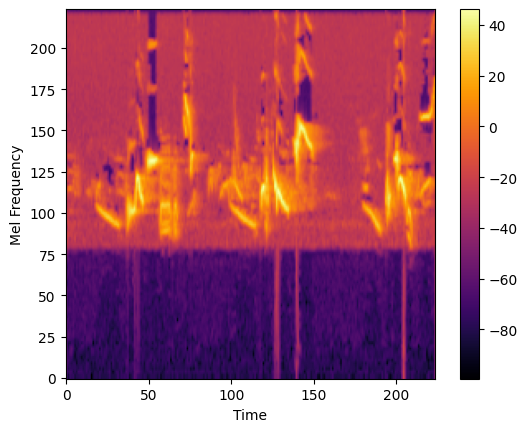

In [ ]:
visualize_wave(spec_tensor[1][0])

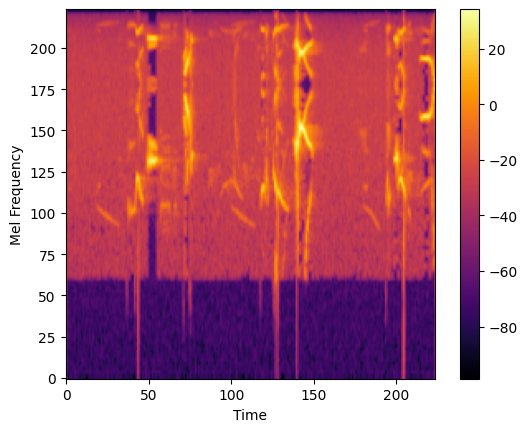

In [ ]:
visualize_wave(spec_wave_tensor[1][1]) # low

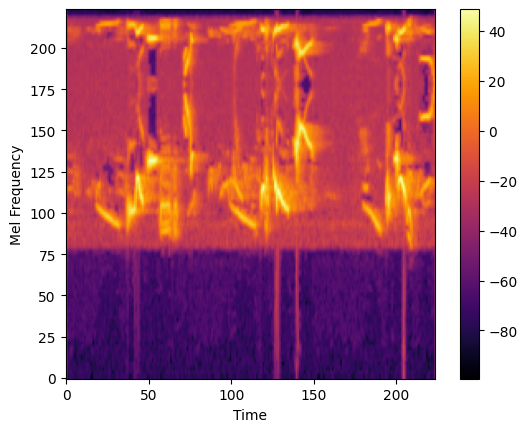

In [ ]:
visualize_wave(spec_wave_tensor[1][0]) # high

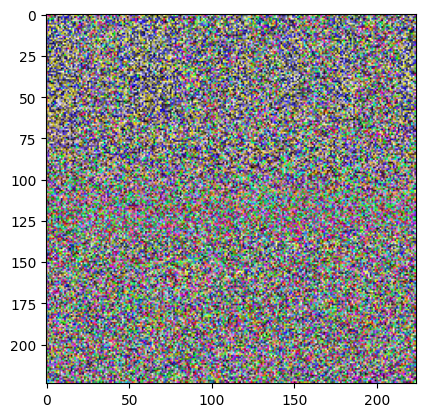

In [ ]:
plt.imshow(transforms.ToPILImage()(cat_wave[0]), cmap='gray')
plt.show()

# Model Declaration

In [ ]:
# class YTMNet(nn.Module):
#   def __init__(self, num_classes: int):
#     super(YTMNet, self).__init__()
    
#     self.to_intervals = ToIntervals()
#     self.transforms = AudioTransforms()
#     self.wavelet_transforms = nn.Sequential(
#         WaveletTransform(pywt.Wavelet('sym4'), 1000),
#         nn.Upsample(scale_factor=2)
#     )
#     self.resize = transforms.Resize((224, 224))
    
#     self.aug = AudioAugmentations()
#     self.tensored = Tensored()

#     # model = models.mobilenet_v3_large()
#     model = models.mobilenet_v3_small(
#         models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
#     )
#     # model.classifier = nn.Sequential(
#     #     nn.Linear(980, 1280, bias=True),
#     #     nn.Hardswish(),
#     #     nn.Dropout(0.2, True),
#     #     nn.Linear(1280, num_classes, bias=True)
#     # )
#     # model.classifier[-1] = nn.Linear(1280, num_classes, bias=True)
#     model.classifier[-1] = nn.Linear(1024, num_classes, bias=True)
  
#     self.model = model

#   def forward(
#       self, X: np.ndarray | Tensor, 
#       labels: torch.Tensor | None = None,
#       input_is_interval = False
#   ) -> torch.Tensor:
#     if not input_is_interval: 
#       X, labels = self.to_intervals(X, labels)
#     wavelets = self.wavelet_transforms(X)
#     if labels is not None: labels = labels.to(device)

#     X = torch.cat((X, wavelets), dim=1).to(device)

#     X = self.transforms(X)
#     X = self.resize(X)
    
#     if self.training: X = self.aug(X)
#     X = self.tensored(X).to(device)

#     logits = self.model(X)
#     probas = torch.softmax(logits, dim=1)
#     return logits, probas, labels

In [ ]:
class YTMNet(nn.Module):
  def __init__(self, num_classes: int):
    super(YTMNet, self).__init__()
    
    self.to_intervals = ToIntervals()
    self.wavelet_transforms = nn.Sequential(
        WaveletTransform(pywt.Wavelet('sym4'), 1000),
        nn.Upsample(scale_factor=2)
    )
    self.transforms = AudioTransforms()
    self.resize = transforms.Resize((224, 224))
    
    self.aug = AudioAugmentations()
    self.tensored = Tensored()

    self.cnn1 = nn.Conv2d(1, 3, kernel_size=3, padding=1)

    # model = models.mobilenet_v3_large()
    model = models.mobilenet_v3_small(
        models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
    )
    # model.classifier = nn.Sequential(
    #     nn.Linear(980, 1280, bias=True),
    #     nn.Hardswish(),
    #     nn.Dropout(0.2, True),
    #     nn.Linear(1280, num_classes, bias=True)
    # )
    # model.classifier[-1] = nn.Linear(1280, num_classes, bias=True)
    model.classifier[-1] = nn.Linear(1024, num_classes, bias=True)
  
    self.model = model

  def forward(
      self, X: np.ndarray | Tensor, 
      labels: torch.Tensor | None = None,
      input_is_interval = False
  ) -> torch.Tensor:
    if not input_is_interval: 
      X, labels = self.to_intervals(X, labels)
    # wavelets = self.wavelet_transforms(X)
    if labels is not None: labels = labels.to(device)

    # X = torch.cat((X, wavelets), dim=1).to(device)
    X = X.to(device)

    X = self.transforms(X)
    X = self.resize(X)
    
    if self.training: X = self.aug(X)
    X = self.tensored(X).to(device)
    
    X = self.cnn1(X)
    logits = self.model(X)
    probas = torch.softmax(logits, dim=1)
    return logits, probas, labels

In [ ]:
model = YTMNet(len(dataset.labels)).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


# Training

## Imports

In [ ]:
import torch.nn.functional as F
from torch import optim
from datetime import datetime
from typing import Tuple, Callable

## Loss, Optimizer, and Intervals

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
to_interval = ToIntervals()

## Function Declarations

In [ ]:
def cat_none(tensor1: Tensor | None, tensor2: Tensor) -> Tensor:
  if tensor1 is None:
      tensor1 = tensor2
  else:
      tensor1 = torch.cat((tensor1, tensor2), dim=0)
  return tensor1

def process_microbatch(
    model: nn.Module, inputs: torch.Tensor,
    labels: torch.Tensor, microbatch_size = 10
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
  inputs, labels = to_interval(inputs, labels)
  end_idx = 0
  cat_logits = None
  cat_probas = None

  for i in range(labels.shape[0] // microbatch_size):
    logits = None
    probas = None
    start = end_idx
    end_idx += microbatch_size

    if end_idx >= labels.shape[0]:
        logits, probas, _ = model(inputs[start:])
    else:
        logits, probas, _ = model(inputs[start:end_idx])
    
    cat_logits = cat_none(cat_logits, logits)
    cat_probas = cat_none(cat_probas, probas)

  if end_idx < labels.shape[0]:
    logits, probas, _ = model(inputs[end_idx:])
    cat_logits = cat_none(cat_logits, logits)
    cat_probas = cat_none(cat_probas, probas)

  return cat_logits, cat_probas, labels

In [ ]:
def evaluate(
    model: nn.Module, dataloader: DataLoader, 
    loss_fn: nn.Module, device: torch.device | None = None
) -> Tuple[float, float]:
  model.eval()
  total_loss = 0.0
  total_correct = 0
  
  with torch.no_grad():
    for inputs, labels in dataloader:
      # inputs, labels = inputs.to(device), labels.to(device)
      # logits, outputs = model(inputs)
      logits, outputs, labels = process_microbatch(model, inputs, labels)
      labels = labels.to(device)
      loss = loss_fn(logits, labels)
      total_loss += loss.item()
      
      preds = torch.argmax(outputs, dim=1)
      total_correct += torch.sum(preds == labels).item()
  
  avg_loss = total_loss / len(dataloader)
  accuracy = total_correct / len(dataloader.dataset)
  
  return avg_loss, accuracy

In [ ]:
def train_one_epoch(
    model: nn.Module, dataloader: DataLoader, 
    optimizer: torch.optim.Optimizer, loss_fn: nn.Module, 
    device: str, epoch: int
  ) -> float:
    model.train()
    total_loss = 0.0
    
    for i, (inputs, labels) in enumerate(dataloader):
      # inputs, labels = inputs.to(device), labels.to(device)
      
      optimizer.zero_grad()
      
      # logits, outputs = model(inputs)
      logits, outputs, labels = process_microbatch(model, inputs, labels)
      labels = labels.to(device)
      loss = loss_fn(logits, labels)
      loss.backward()
      optimizer.step()
      
      cost = loss.item()
      total_loss += cost
      
      # Log loss every 50 batches
      if (i+1) % 50 == 0:
        print('Epoch: %05d/%05d | Batch %05d/%05d | Batch Cost: %.4f |' 
                %(epoch + 1, num_epochs, i + 1, 
                len(dataloader), cost))
            
    return total_loss / len(dataloader)

In [ ]:
def train(
    model: nn.Module, train_dl: DataLoader, valid_dl: DataLoader, 
    optimizer: torch.optim.Optimizer, loss_fn: nn.Module, epochs: int, 
    device: torch.device | None = None
  ) -> None:
    best_valid_loss = float('inf')
    best_acc = 0.
    timestamp = datetime.now()
    
    for epoch in range(epochs):
        # Train for one epoch
        train_loss = train_one_epoch(
            model, train_dl, optimizer, 
            loss_fn, device, epoch
        )
        
        # Evaluate on validation set
        valid_loss, valid_acc = evaluate(model, valid_dl, loss_fn, device)
        
        if valid_acc > best_acc:
          best_acc = valid_acc
          print('Better model: saving to disk.')
          state = {
            'model': model.state_dict(),
            'best_acc': best_acc,
            'epoch': epoch,
            'optimizer': optimizer.state_dict(),
          }
          if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
          model_path = f'model_{timestamp}_{epoch}'
          torch.save(state, model_path)
        
        # Print epoch summary
        print(f'Epoch {epoch + 1:03}/{epochs:03} | ' + 
              f'Train Loss: {train_loss:.4f} | ' + 
              f'Valid Loss: {valid_loss:.4f} | ' + 
              f'Valid Acc: {valid_acc:.4f}'
        )

In [ ]:
train(model, train_dl, valid_dl, optimizer, loss_fn, num_epochs, device)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 00001/00005 | Batch 00050/01187 | Batch Cost: 5.6473 |
Epoch: 00001/00005 | Batch 00100/01187 | Batch Cost: 5.6262 |
Epoch: 00001/00005 | Batch 00150/01187 | Batch Cost: 5.5453 |
Epoch: 00001/00005 | Batch 00200/01187 | Batch Cost: 5.6314 |
Epoch: 00001/00005 | Batch 00250/01187 | Batch Cost: 5.5755 |
Epoch: 00001/00005 | Batch 00300/01187 | Batch Cost: 5.5576 |
Epoch: 00001/00005 | Batch 00350/01187 | Batch Cost: 5.5797 |
Epoch: 00001/00005 | Batch 00400/01187 | Batch Cost: 5.6134 |
Epoch: 00001/00005 | Batch 00450/01187 | Batch Cost: 5.5953 |
Epoch: 00001/00005 | Batch 00500/01187 | Batch Cost: 5.6206 |
Epoch: 00001/00005 | Batch 00550/01187 | Batch Cost: 5.6201 |
Epoch: 00001/00005 | Batch 00600/01187 | Batch Cost: 5.6357 |
Epoch: 00001/00005 | Batch 00650/01187 | Batch Cost: 5.6594 |
Epoch: 00001/00005 | Batch 00700/01187 | Batch Cost: 5.5949 |
Epoch: 00001/00005 | Batch 00750/01187 | Batch Cost: 5.5802 |
Epoch: 00001/00005 | Batch 00800/01187 | Batch Cost: 5.5881 |
Epoch: 0

In [ ]:
# to intervals has a problem